In [1]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.combine_tools import apply_qc
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
warnings.filterwarnings('ignore')

%matplotlib inline

# Load data

In [2]:
criteria_name = 'beh_all'
beh_criteria = 'beh_all_beh'
version = 'PrL_S1'

In [3]:
def to_str_intlike(x):
    """
    Convert any integer-like or numeric-like value to a clean string without '.0'.

    Examples:
        297       → '297'
        '297.0'   → '297'
        297.0     → '297'
        np.int64(297) → '297'
        'abc'     → 'abc'   (unchanged)
        np.nan    → np.nan   (kept as NaN)
    """
    if pd.isna(x):
        return np.nan  # or return '' if you prefer empty string for NaN

    # Try to convert to float first (handles both numeric and numeric-like strings)
    try:
        val = float(x)
        # If it's a whole number like 297.0 → cast to int and then str
        if val.is_integer():
            return str(int(val))
        else:
            # Keep decimals if not an integer-like number
            return str(val)
    except (ValueError, TypeError):
        # Non-numeric string: return as-is
        return str(x)


In [4]:
# load waveforms
waveform_criteria = 'waveform_all'
waveform_type = '_raw'
wf_folder  = os.path.join('/root/capsule/scratch/combined/wf_plots', waveform_criteria, waveform_type)
wf_feature_file = os.path.join(wf_folder, 'wf_features_combined.pkl')
with open(wf_feature_file, 'rb') as f:
    wf_features = pickle.load(f)
wf_features.rename(columns={'unit': 'unit_id'}, inplace=True)
wf_features['unit_id'] = wf_features['unit_id'].apply(to_str_intlike)
wf_features.drop(columns=['probe'], inplace=True)

In [5]:
# load basic ephys
be_criteria = 'basic_ephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', be_criteria)
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [6]:
# load basic constraints and data (unit + behavior)
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# behavior 
with open(os.path.join('/root/capsule/scratch/combined/combined_session_tbl', 'combined_beh_sessions.pkl'), 'rb') as f:
    combined_session_qc = pickle.load(f)
combined_session_qc.drop(columns=['probe'], inplace=True, errors='ignore')
combined_tagged_units = combined_tagged_units.merge(combined_session_qc, on='session', how='left')

# antidromic data
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys_low/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)

with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying conditional bounds for isi_violations
 - isi_violations: 17847 -> 8175 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8175 -> 5798 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5798 -> 5775 units passed
Applying items for in_df: [True]
 - in_df: 5775 -> 4247 units passed
Applying conditional bounds for y_loc
 - y_loc: 4247 -> 2993 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2993 -> 2993 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 323
Number of non-opto units after filtering: 2993


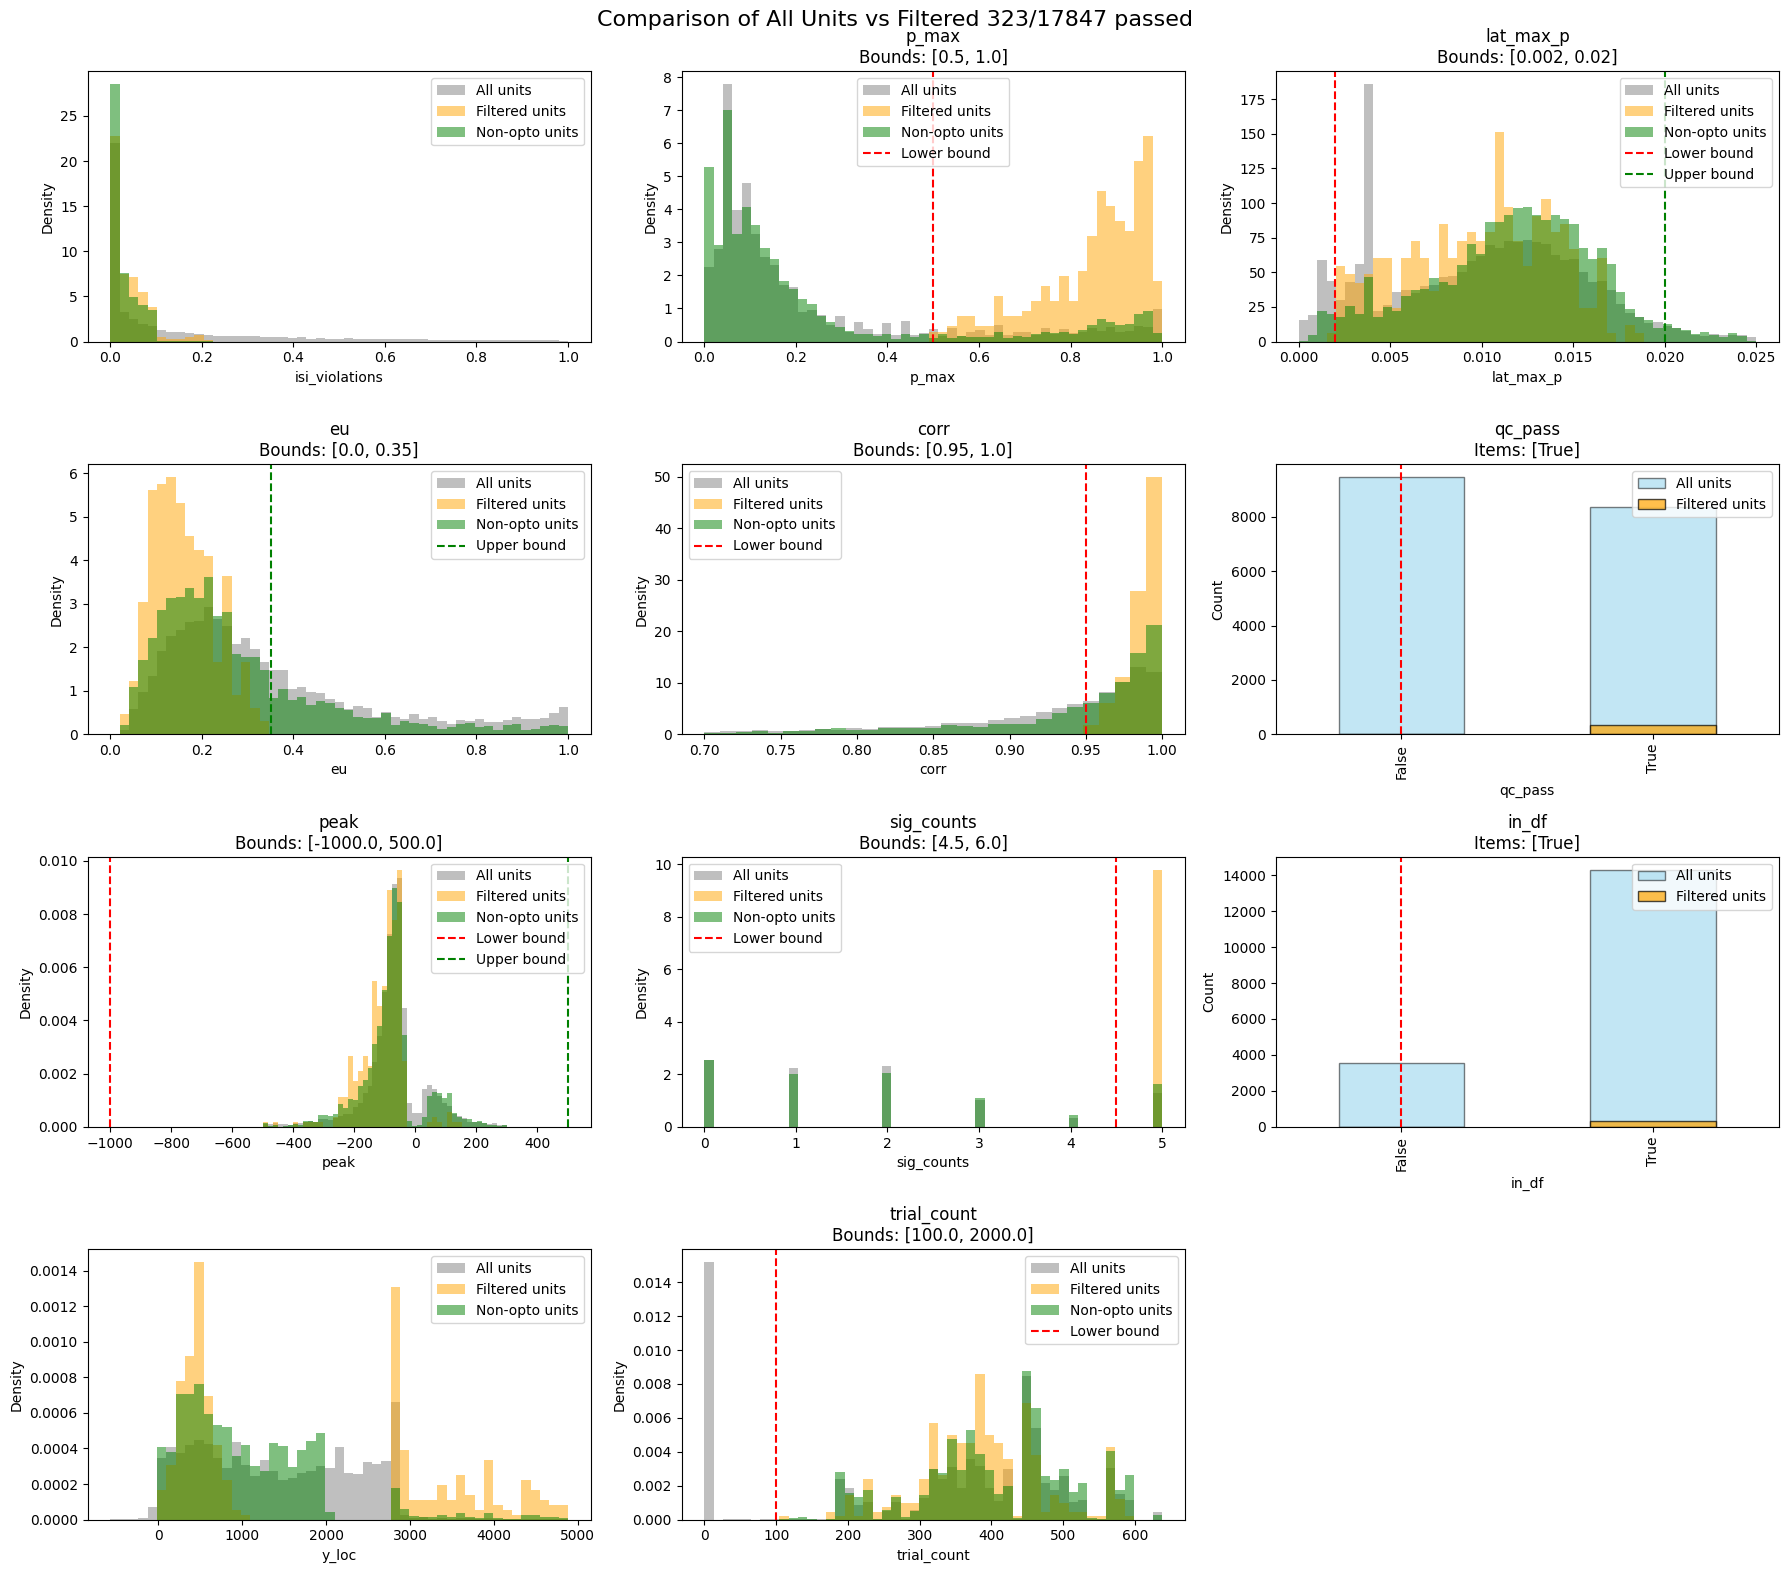

In [7]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 17847 -> 8148 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8148 -> 5771 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5771 -> 5748 units passed
Applying items for in_df: [True]
 - in_df: 5748 -> 4224 units passed
Applying conditional bounds for y_loc
 - y_loc: 4224 -> 2970 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 2970 -> 2970 units passed
Applying bounds for session_len: [100, 2000]
 - session_len: 2970 -> 2821 units passed
Applying bounds for p_sw_L: [0.05, 1]
 - p_sw_L: 2821 -> 2707 units passed
Applying bounds for aN: [0.05, 1.0]
 - aN: 2707 -> 2705 units passed
Applying bounds for diff_1: [0, 'nan']
 - diff_1: 2705 -> 2705 units passed
Applying bounds for intercept: [-3, 3]
 - intercept: 2705 -> 2656 units passed
Applying bounds for sw_bias: [-1, 1]
 - sw_bias: 2656 -> 2656 units passed
Applying items for lick_bias: [False]
 - lick_bias: 2656 -> 2120 unit

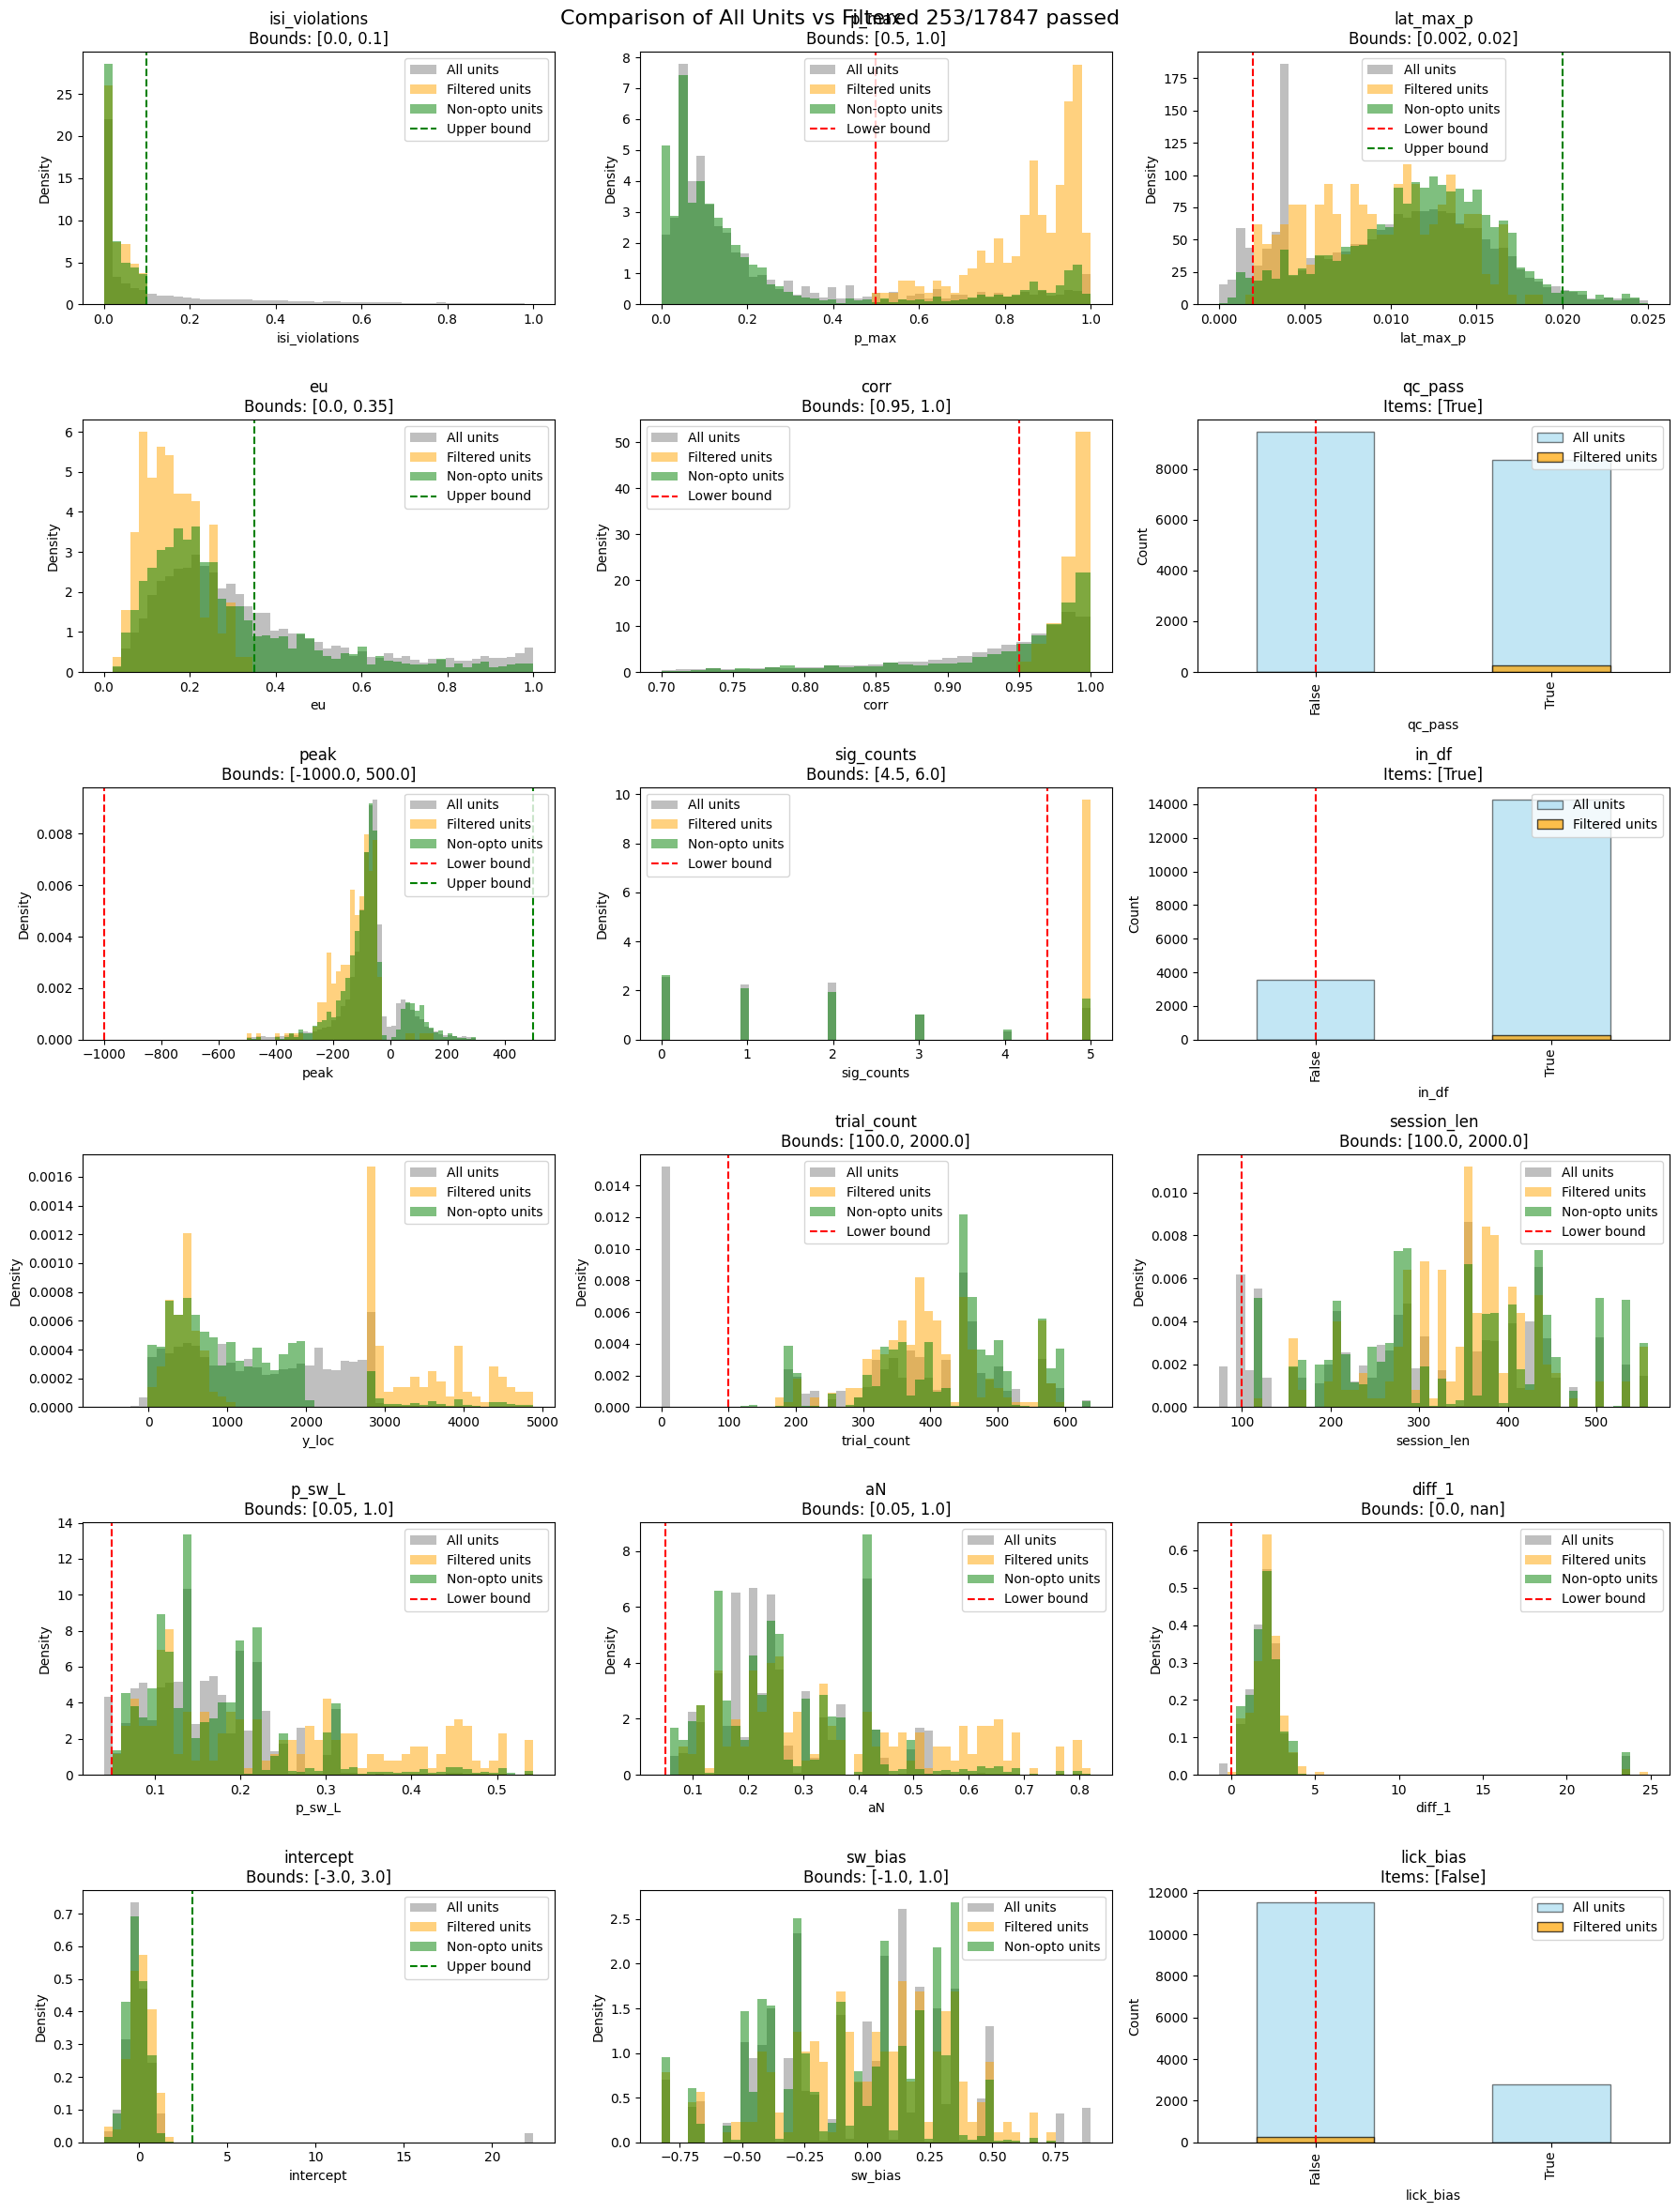

In [8]:
combined_tagged_units_filtered_beh, combined_tagged_units_beh, fig = apply_qc(combined_tagged_units, beh_constraints)

In [13]:
combined_tagged_units_beh.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_beh['unit_id'] = combined_tagged_units_beh['unit_id'].apply(to_str_intlike)

In [14]:
# load and add model variables
model_combined = pd.read_csv(os.path.join(beh_folder, 'figures_in_generation', f'model_combined_{criteria_name}.csv'), index_col=0)
model_combined['theta'] = model_combined['theta'] - 0.5
model_combined['unit_id'] = model_combined['unit_id'].apply(to_str_intlike)

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)
model_combined = model_combined.merge(combined_tagged_units_beh[['session', 'unit_id', 'selected']], on=['session', 'unit_id'], how='left')
# model_combined = model_combined[model_combined['selected']]

In [34]:
# Combine all features
features_combined = pd.merge(model_combined, wf_features, on=['session', 'unit_id'], suffixes=('', '_wf'), how='outer')
features_combined = pd.merge(features_combined, basic_ephys_df, on=['session', 'unit_id'], suffixes=('', '_be'), how='outer')
response_tbl = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all/response_ratio_beh_all_go_cue.csv')
response_tbl['unit_id'] = response_tbl['unit'].apply(to_str_intlike)
features_combined = features_combined.merge(response_tbl, on=['session', 'unit_id'], how='outer')

# features_combined = features_combined.merge(antidromic_df, on=['session', 'unit_id'], how='outer')
features_combined = features_combined.merge(combined_tagged_units[['session', 'unit_id', 'probe', 'x_ccf', 'y_ccf', 'z_ccf', 'tier_1', 'tier_2', 'isi_violations']], on=['session', 'unit_id'], how='left')
features_combined['be_filter'].fillna(False, inplace=True)
features_combined['selected'].fillna(False, inplace=True)

# Behavior and spatial 

## Scatter and polar

In [105]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'com'
verion = 'mc'  # 'ori' or 'mc'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome


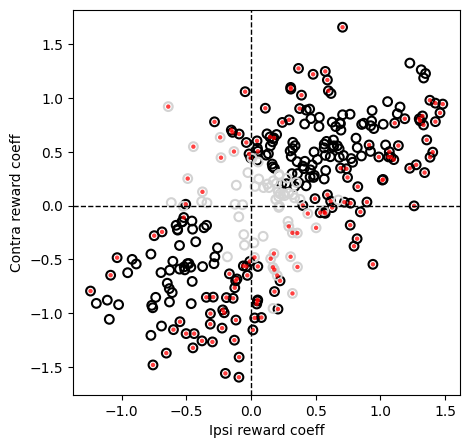

<Figure size 640x480 with 0 Axes>

In [106]:
# compare ipsi vs contra responses
ipsi_reward_coeff = curr_coefs_outcome + curr_coefs_int
contra_reward_coeff = curr_coefs_outcome - curr_coefs_int

# scatter
plt.figure(figsize=(5, 5))
plt.scatter(ipsi_reward_coeff[curr_p_outcome<0.05], contra_reward_coeff[curr_p_outcome<0.05], 
            alpha=1, edgecolors='k', color='none', s=40, linewidths=1.5)
plt.scatter(ipsi_reward_coeff[curr_p_outcome>=0.05], contra_reward_coeff[curr_p_outcome>=0.05],
            alpha=1, edgecolors='lightgray', color='none', s=40, linewidths=1.5)
mask = curr_p_int<0.05
plt.scatter(ipsi_reward_coeff[mask], contra_reward_coeff[mask],
            alpha=0.75, edgecolors='none', color='red', s=10)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.axvline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Ipsi reward coeff')
plt.ylabel('Contra reward coeff')
plt.show()
plt.savefig(os.path.join(beh_folder, f'ipsi_vs_contra_reward_coeff_{criteria_name}.pdf'), bbox_inches='tight')

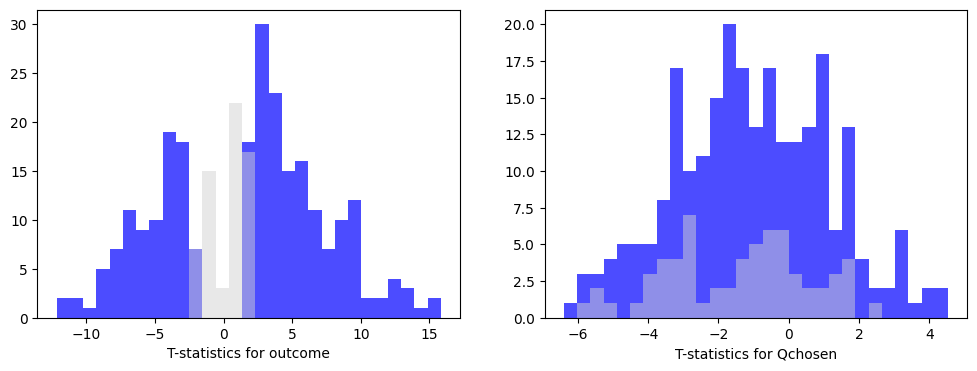

In [107]:
# histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bins = np.linspace(np.nanmin(curr_T_outcome)-0.01, np.nanmax(curr_T_outcome)+0.01, 30)
plt.hist(curr_T_outcome[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_outcome[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for outcome')

plt.subplot(1, 2, 2)
bins = np.linspace(np.nanmin(curr_T_q)-0.01, np.nanmax(curr_T_q)+0.01, 30)
plt.hist(curr_T_q[curr_p_outcome<0.05], bins=bins, color='blue', alpha=0.7, edgecolor='none')
plt.hist(curr_T_q[curr_p_outcome>=0.05], bins=bins, color='lightgray', alpha=0.5, edgecolor='none')
plt.xlabel('T-statistics for Qchosen')
plt.savefig(os.path.join(beh_folder, f'T_statistics_outcome_Qchosen_focus_wind_{criteria_name}.pdf'), bbox_inches='tight')


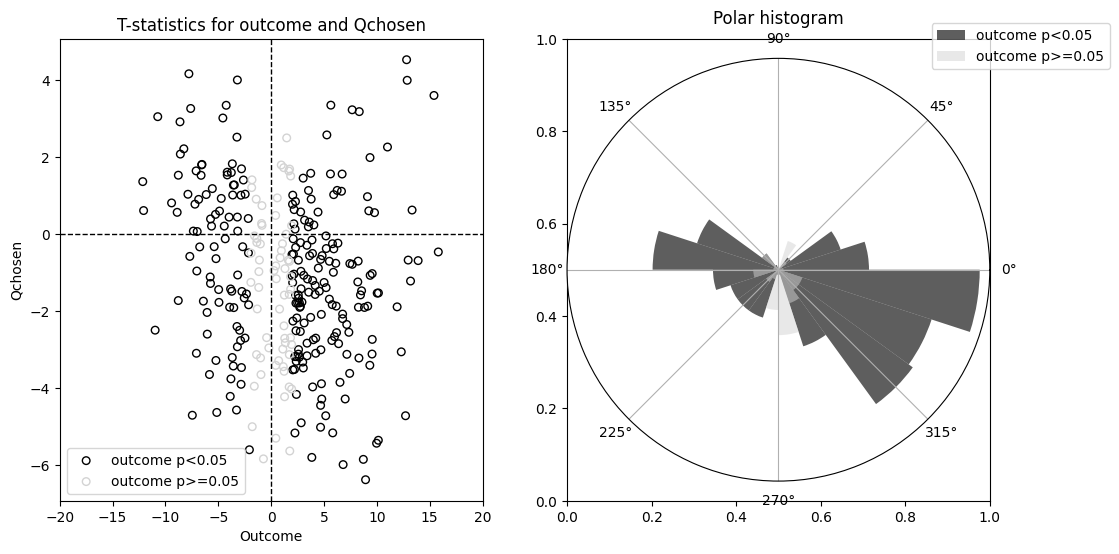

In [108]:
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(curr_T_outcome[curr_p_outcome<0.05], curr_T_q[curr_p_outcome<0.05], color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
axes[0].scatter(curr_T_outcome[curr_p_outcome>=0.05], curr_T_q[curr_p_outcome>=0.05], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()
axes[0].set_xlim([-20, 20])

# polar
thresh = 0.05
all_vec = np.column_stack((curr_coefs_outcome[curr_p_outcome<thresh], curr_coefs_q[curr_p_outcome<thresh]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
all_vec_low = np.column_stack((curr_coefs_outcome[curr_p_outcome>=thresh], curr_coefs_q[curr_p_outcome>=thresh]))
all_vec_low = all_vec_low.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
theta_low, rho_low = np.arctan2(all_vec_low[:, 1], all_vec_low[:, 0]), np.hypot(all_vec_low[:, 1], all_vec_low[:, 0])
# Define histogram edges (bins) from -π to π
edges = np.linspace(-np.pi, np.pi, 4*5+1)
# Create polar histogram
axes[1] = fig.add_subplot(122, polar=True)
axes[1].hist(theta, bins=edges, color=[0.1, 0.1, 0.1], alpha=0.7, edgecolor='none', density=False, label='outcome p<0.05')
axes[1].hist(theta_low, bins=edges, color='lightgray', alpha=0.5, edgecolor='none', density=False, label='outcome p>=0.05')
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
# plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')

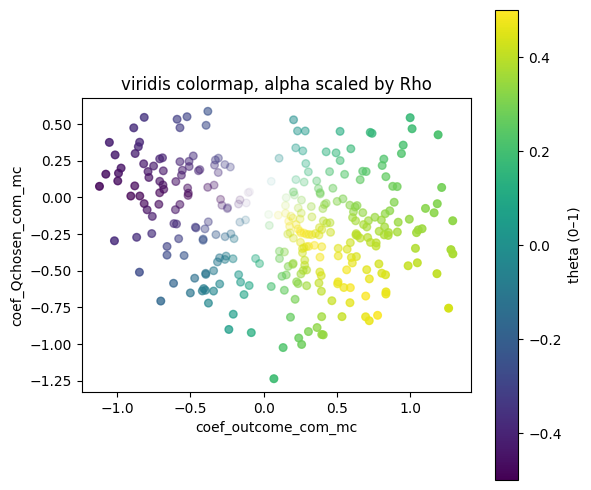

In [109]:
import matplotlib.pyplot as plt
import numpy as np

theta = model_combined['theta'].values

# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(theta))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

# Create a standalone ScalarMappable for the colorbar
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Attach colorbar to this axis
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("theta (0–1)")

ax.set_xlabel("coef_outcome_com_mc")
ax.set_ylabel("coef_Qchosen_com_mc")
ax.set_title("viridis colormap, alpha scaled by Rho")
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()


In [89]:
# load
# model_combined = pd.read_csv(os.path.join(beh_folder, f'model_combined_{criteria_name}.csv'))
# model_combined_anti = pd.read_csv('/root/capsule/scratch/combined/beh_plots/beh_all_anti/model_combined_beh_all_anti.csv')


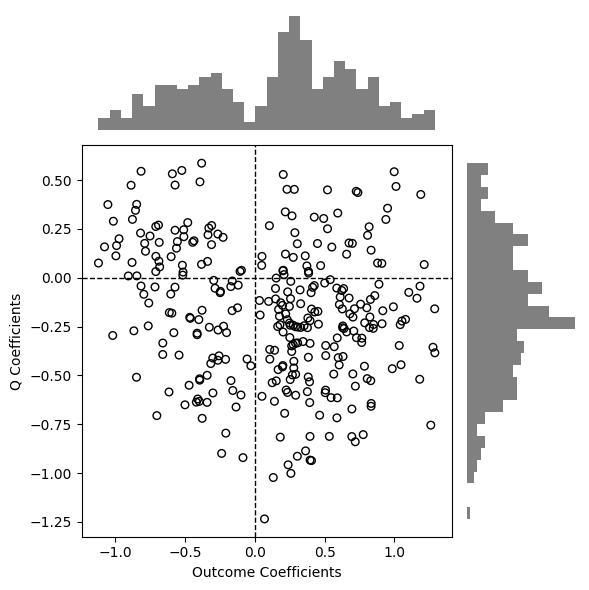

In [110]:
# scatter and polar of 'outcome' and 'Qchosen'
c_or_t = 'T'

curr_p_int = model_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = model_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = model_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = model_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = model_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = model_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = model_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome


# curr_T_outcome = all_Tm[:, outcome_ind]  # get the T-statistics for the reward outcome
# curr_T_q = all_Tm[:, q_ind]  # get the T-statistics for the Qchosen
# curr_p_outcome = all_pm[:, outcome_ind]  # get the p-values for the reward outcome

# curr_T_outcome = model_combined['outcome_T'].values  # get the T-statistics for the reward outcome
# curr_T_q = model_combined['Qchosen_T'].values  # get the T-statistics for the Qchosen
# curr_p_outcome = model_combined['outcome_p'].values  # get the p-values for the reward outcome

# curr_coefs_outcome = model_combined['outcome_coef'].values  # get the coefficients for the reward outcome
# curr_coefs_q = model_combined['Qchosen_coef'].values  # get the coefficients for the Qchosen
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Example data
# curr_coefs_outcome = ...
# curr_coefs_int = ...

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome, curr_coefs_q, color='none', edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Q Coefficients')

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_q, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


# plot behavior coeffs in space

In [17]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'red'), (0.5, 'white'), (1.0, 'blue')]
)

features_beh = model_combined.columns.tolist()
features_beh.remove('session')
features_beh.remove('unit_id')
# drop all features ending with '_p'
features_beh = [f for f in features_beh if not f.startswith('p_') and not f.endswith('_p')]
features_beh.append('T')
features_beh.remove('selected')

In [22]:
features_resp = response_tbl.columns.tolist()
features_resp = [f for f in features_resp if ('T_' in f) and ('Intercept' not in f) and ('amp' not in f)]
features_resp

['T_ratio_hit',
 'T_baseline_hit',
 'T_response_hit',
 'T_ratio_svs',
 'T_baseline_svs',
 'T_response_svs',
 'T_ratio_ipsi',
 'T_baseline_ipsi',
 'T_response_ipsi']

## Spatial distribution of values, face

In [19]:
features_to_plot = ['outcome_contra', 'outcome_ipsi', 'theta_com',
                    't_outcome|(|t_outcome| + |t_Q|)', 'coef_outcome|(|coef_outcome| + |coef_Q|)',
                    'T', 'coef_ipsi_com_mc', 'coef_ipsi_l_ori', 'coef_Qchosen_l_ori',
                    'T_ipsi_e_mc', 'T_ipsi_l_mc']

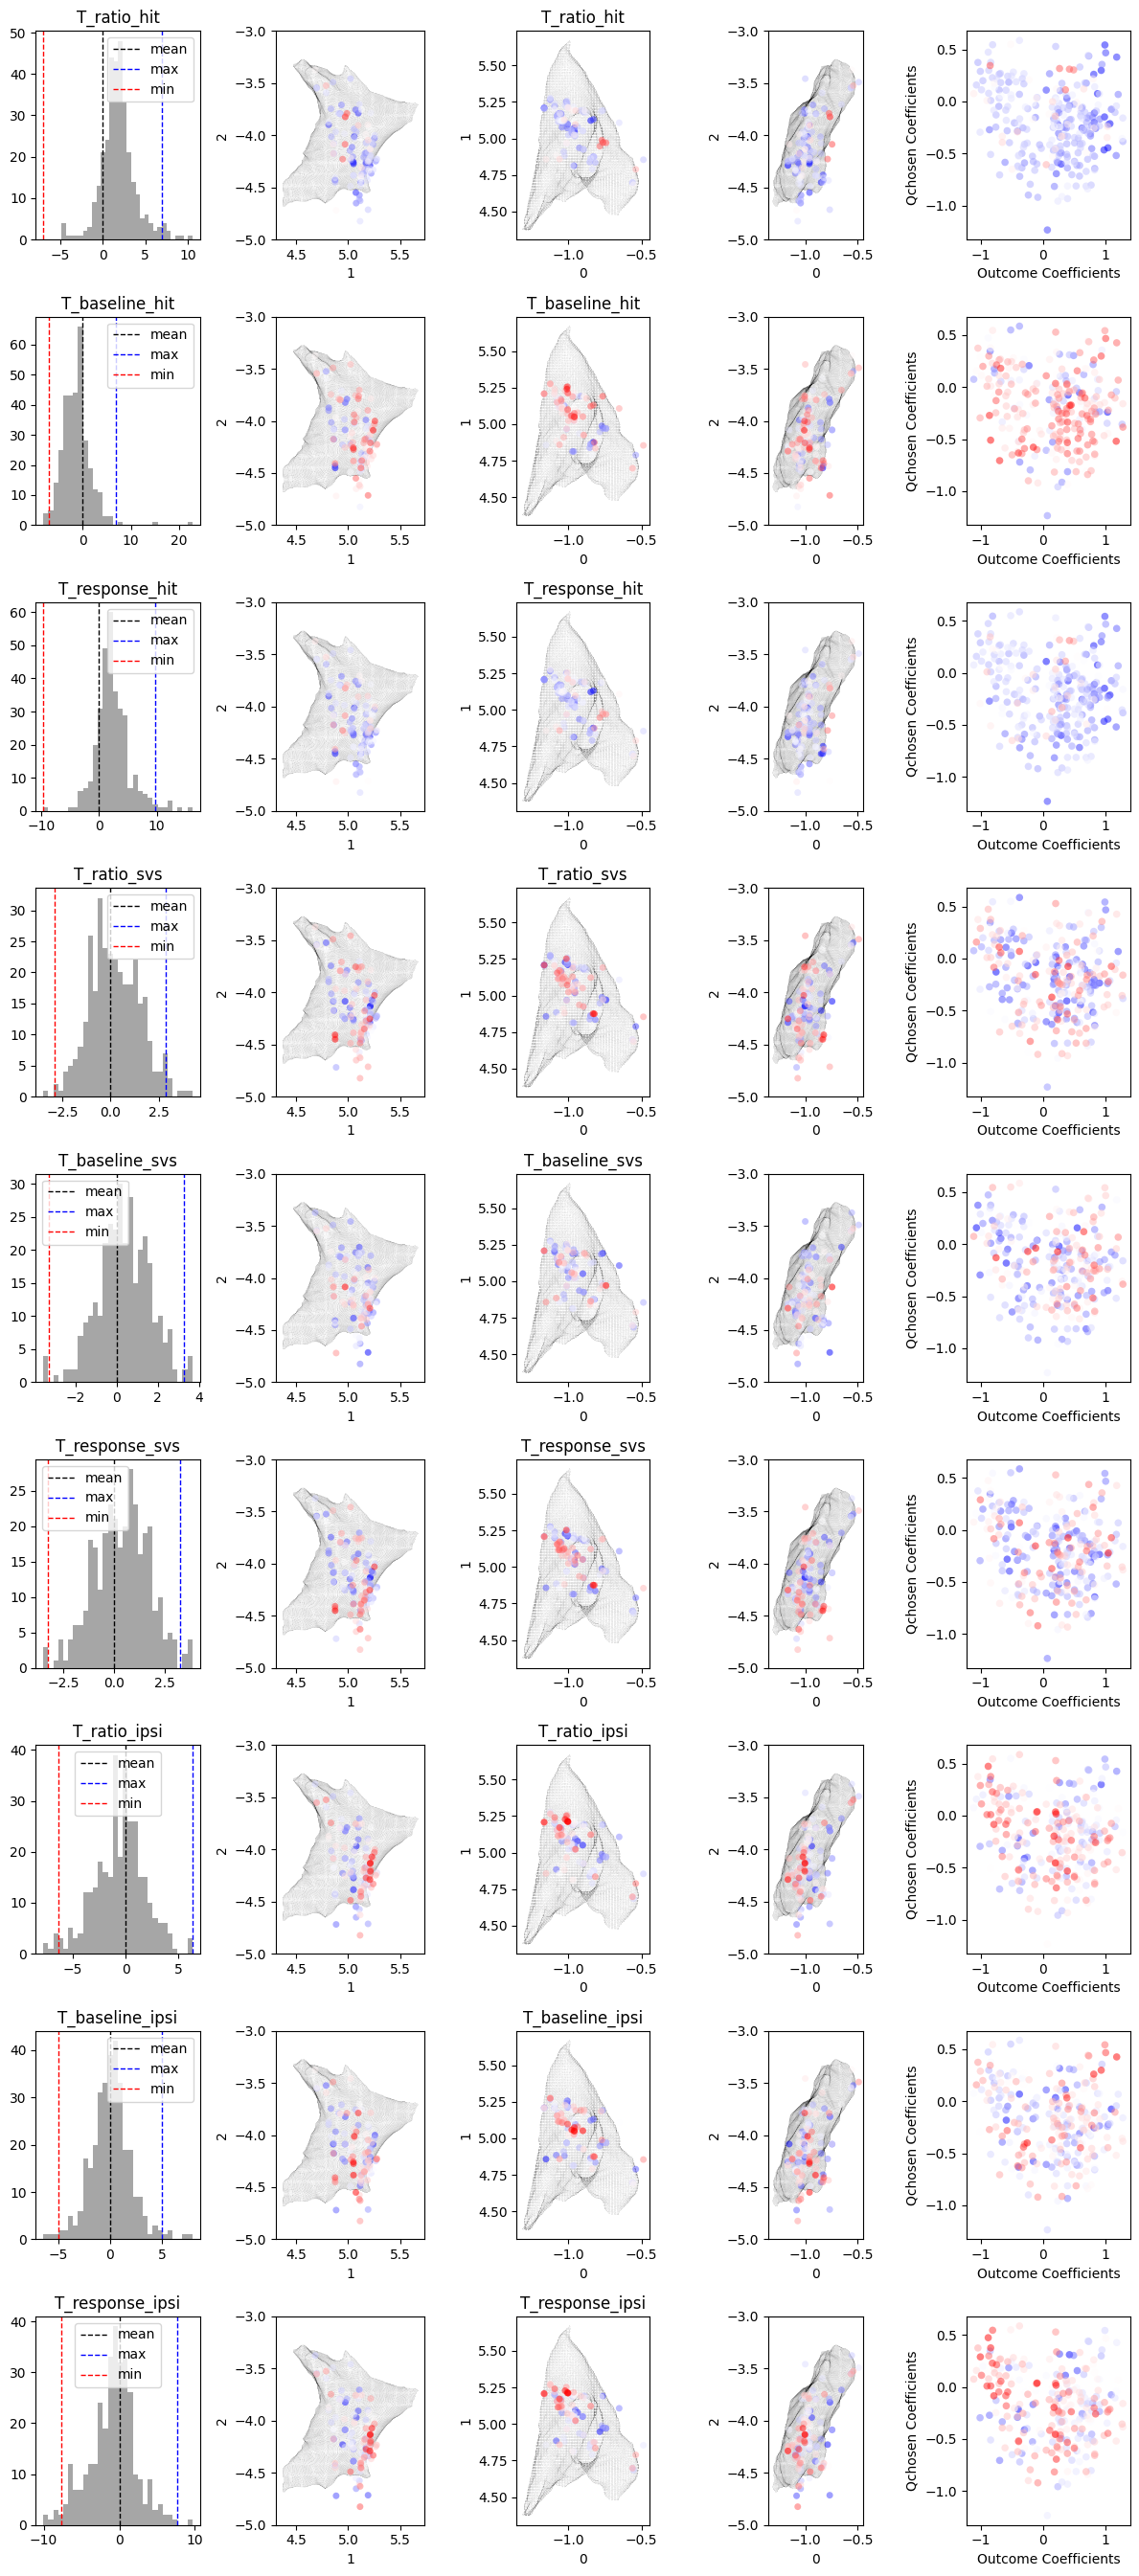

In [23]:
p_curr = features_combined['p_outcome_com_mc'].values
mask = p_curr < 1
mask = mask & features_combined['be_filter'].values
# mask = mask & features_combined['selected'].values
# features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta_e', 'theta_l', 'theta_com', 'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)']
features_to_plot = features_resp
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = features_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize colors to 0–1 ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg))/(amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        # === Colormap ===
        custom_cmap = LinearSegmentedColormap.from_list('white_red', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Histogram of feature values ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(features_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label = 'max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label = 'min')
    ax_hist.legend()

    # === Compute alpha scaling from rho ===
    alpha_scale = features_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)               # soften scaling
    alpha_scale = np.clip(alpha_scale, 0.2, 0.8)     # prevent extremes

    # === Sort and filter ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Precompute RGBA facecolors ===
    rgba_colors = custom_cmap(color_reg_plot)
    # rgba_colors[:, -1] = alpha_scale_plot  # inject alpha per point
    rgba_colors[:, -1] = 0.5  # fixed alpha

    # === 2D plane projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # background mesh outline
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.4, s=0.05, edgecolors='none'
        )

        # scatter the points (alpha-scaled)
        sc = ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors=rgba_colors,
            edgecolors='none',
            s=25
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
    
    if len(feature.split("_"))>=2:
        if feature.split("_")[1] in ['e', 'l', 'com']:
            period = feature.split("_")[1]
        else:
            period = 'com'
    else:
        period = 'com'
    ax = axes[ind, -1]
    ax.scatter(
        features_combined[f'coef_outcome_{period}_mc'][mask].values[sort_ind],
        features_combined[f'coef_Qchosen_{period}_mc'][mask].values[sort_ind],
        color=rgba_colors, edgecolors='none', s=30
    )
    ax.set_xlabel('Outcome Coefficients')
    ax.set_ylabel('Qchosen Coefficients')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(os.path.join(beh_folder, f'model_combined_spatial_{criteria_name}.{ext}'),
                bbox_inches='tight', dpi=300)
# plt.close()


## Spatial distribution of values, edge

NameError: name 'planes' is not defined

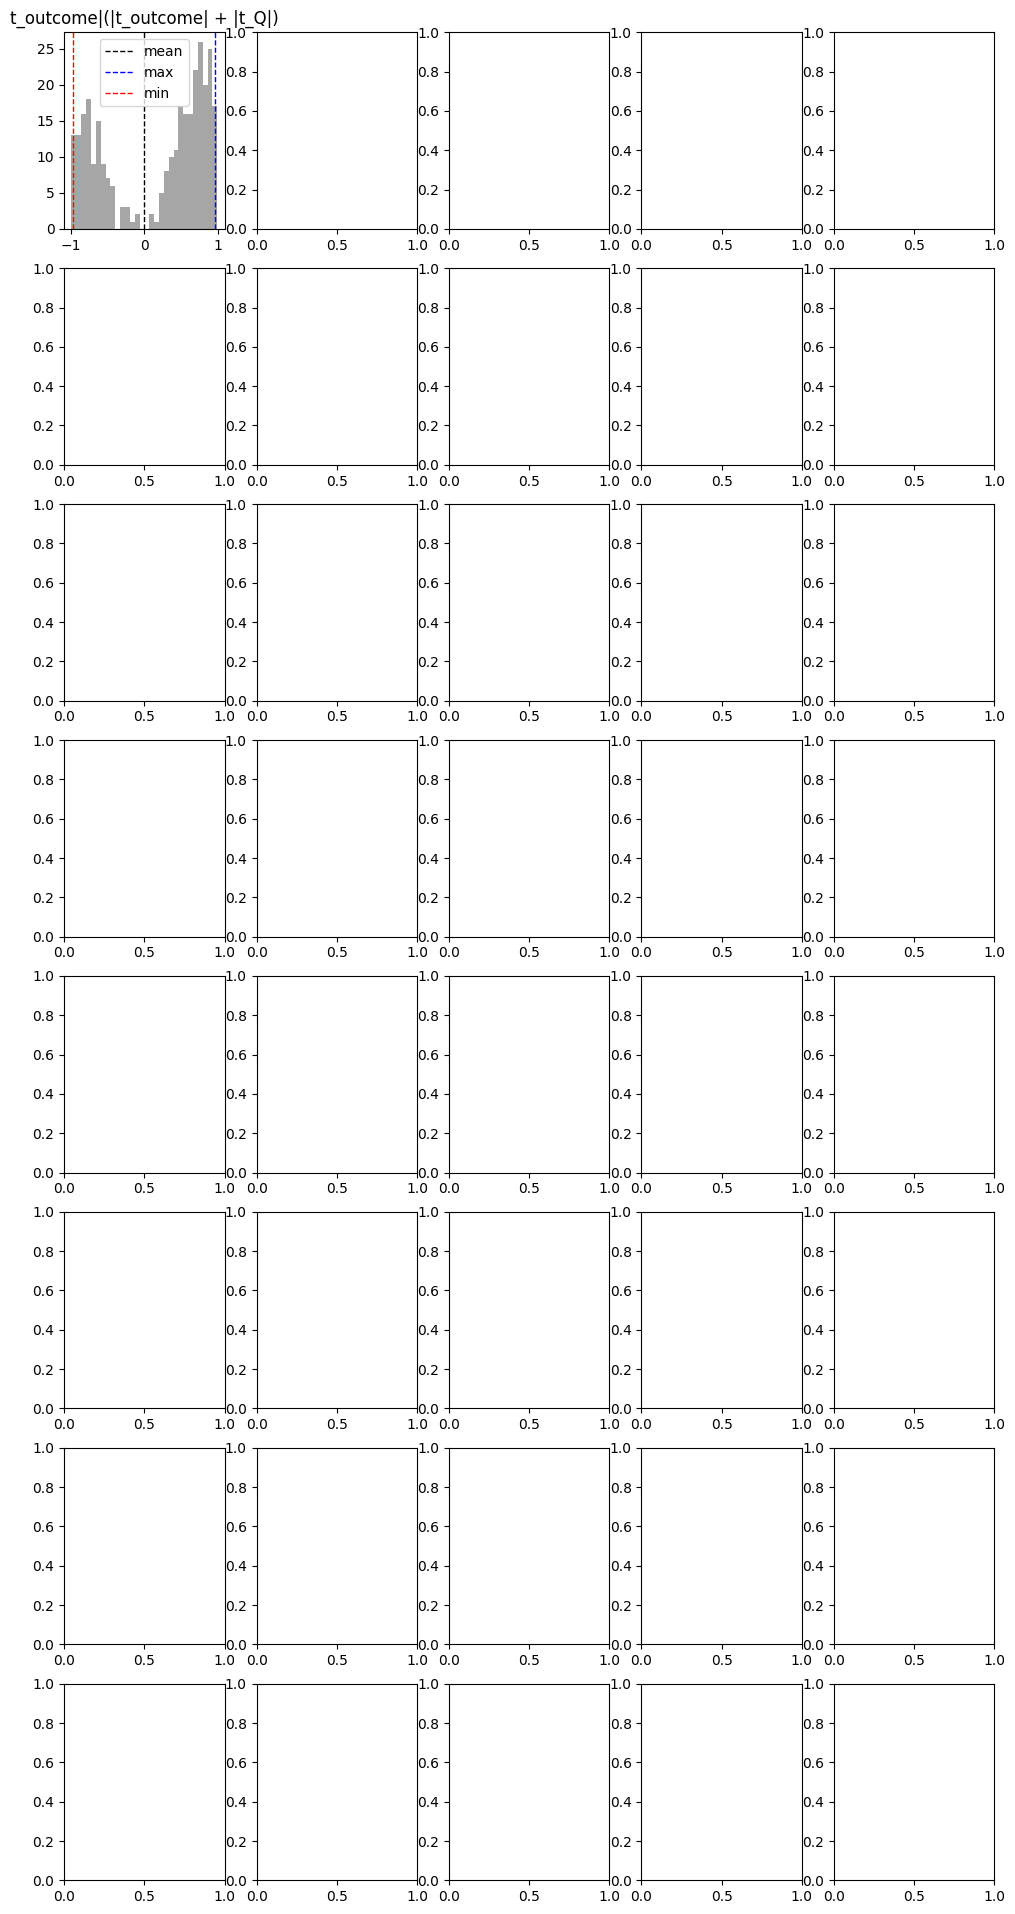

In [90]:
p_curr = model_combined['p_outcome_com_mc'].values
mask = (p_curr < 1)
features_to_plot = [
    't_outcome|(|t_outcome| + |t_Q|)',
    'theta_e', 'theta_l', 'theta_com', 'theta', 'outcome_contra',
    'outcome_ipsi', 'coef_outcome|(|coef_outcome| + |coef_Q|)'
]
# features_to_plot = ['theta']

versions = ['e', 'l', 'com']
for version in versions:
    all_vec = np.column_stack((
        model_combined[f'coef_outcome_{version}_mc'],
        model_combined[f'coef_Qchosen_{version}_ori']
    ))
    theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
    bound_1, bound_2, bound_3 = -(1 / 4) * np.pi, np.pi, -np.pi
    theta_scaled_dis = np.zeros_like(theta)
    for ind, angle_curr in enumerate(theta):
        if bound_1 < angle_curr <= bound_2:
            theta_scaled_dis[ind] = (angle_curr - bound_1) / (bound_2 - bound_1)
        else:
            theta_scaled_dis[ind] = (bound_1 - angle_curr) / (bound_1 - bound_3)
    theta_scaled_dis_all = 1 - theta_scaled_dis - 0.5
    model_combined[f'theta_{version}'] = theta_scaled_dis_all

# derived features
model_combined['coef_outcome|(|coef_outcome| + |coef_Q|)'] = (
    model_combined['coef_outcome_com_mc'] /
    (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
)
model_combined['outcome_ipsi'] = (
    model_combined['coef_outcome_com_mc'] + model_combined['coef_outcome:ipsi_com_mc']
)
model_combined['outcome_contra'] = (
    model_combined['coef_outcome_com_mc'] - model_combined['coef_outcome:ipsi_com_mc']
)

# --- setup figure grid ---
fig, axes = plt.subplots(len(features_to_plot), 5, figsize=(12, 3 * len(features_to_plot)))
axes = np.atleast_2d(axes)

# --- anatomical coordinates ---
ccfs = combined_tagged_units_filtered[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for ind, feature in enumerate(features_to_plot):
    color = model_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === normalize color range ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        center_line = 0
        upper_limit = amp_cut
        lower_limit = -amp_cut
        custom_cmap = LinearSegmentedColormap.from_list(
            'blue_white_red',
            [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.min(color_reg)) / (amp_cut - np.min(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        center_line = np.nanmean(color)
        lower_limit = np.nanmin(np.abs(color)) * np.sign(center_line)
        upper_limit = amp_cut * np.sign(center_line)
        custom_cmap = LinearSegmentedColormap.from_list(
            'white_red', [(0.0, 'white'), (1.0, 'red')]
        )

    color_reg[np.isnan(color_reg)] = 0.5

    # === histogram ===
    ax_hist = axes[ind, 0]
    ax_hist.hist(model_combined[feature].values, bins=30, color='gray', alpha=0.7)
    ax_hist.set_title(feature)
    ax_hist.axvline(center_line, color='k', linestyle='--', linewidth=1, label='mean')
    ax_hist.axvline(upper_limit, color='blue', linestyle='--', linewidth=1, label='max')
    ax_hist.axvline(lower_limit, color='red', linestyle='--', linewidth=1, label='min')
    ax_hist.legend()

    # === alpha scaling (rho) ===
    alpha_scale = model_combined['rho'].values[mask]
    # alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 1)

    # === sorting ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === map color to edge RGBA ===
    edge_rgba = custom_cmap(color_reg_plot)
    # edge_rgba[:, -1] = alpha_scale_plot  # add per-point alpha

    # === 2D projections ===
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='k', alpha=0.3, s=0.05, edgecolors='none'
        )

        # main scatter: edge gradient only
        ax.scatter(
            ccfs_plot[:, planes[plane][0]],
            ccfs_plot[:, planes[plane][1]],
            facecolors='none',
            edgecolors=edge_rgba,
            linewidths=1.5,
            s=30
        )

        if plane == 'hor':
            ax.set_title(feature)
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

        if planes[plane][1] == dv:
            ax.set_ylim([-5, -3])
    
    if len(feature.split("_"))>=2:
        if feature.split("_")[1] in ['e', 'l', 'com']:
            period = feature.split("_")[1]
        else:
            period = 'com'
    else:
        period = 'com'
    ax = axes[ind, -1]
    ax.scatter(
        model_combined[f'coef_outcome_{period}_mc'][mask].values[sort_ind],
        model_combined[f'coef_Qchosen_{period}_mc'][mask].values[sort_ind],
        color='none', edgecolors=edge_rgba, s=30
    )
    ax.set_xlabel('Outcome Coefficients')
    ax.set_ylabel('Qchosen Coefficients')

plt.tight_layout()
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(
        os.path.join(beh_folder, f'model_combined_spatial_edge_{criteria_name}.{ext}'),
        bbox_inches='tight', dpi=300
    )
# plt.close()


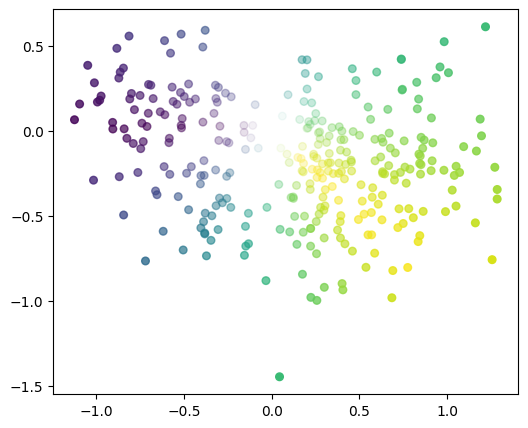

In [107]:
# Define viridis colormap and normalization
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=-0.5, vmax=0.5)

# Alpha = distance from 0.5 → scaled to 0–1 range
alpha_scale = np.sqrt(model_combined['rho'])
alpha_scale = np.clip(alpha_scale, 0, 1.2)
alpha_scale = (alpha_scale - np.min(alpha_scale)) / (np.max(alpha_scale) - np.min(alpha_scale))

# === sorting ===
sort_ind = np.argsort(color_reg[mask])[::-1]
ccfs_plot = ccfs[mask][sort_ind]
color_reg_plot = color_reg[mask][sort_ind]
alpha_scale_plot = alpha_scale[sort_ind]

# Map θ → viridis colors, then inject alpha per point
colors = cmap(norm(model_combined['theta'].values))
colors[:, -1] = alpha_scale  # assign alpha channel

# Create scatter using facecolors directly (so alpha is preserved)
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(
    model_combined['coef_outcome_com_mc'],
    model_combined['coef_Qchosen_com_mc'],
    facecolors=colors,
    edgecolors=None,
    s=30,
    marker='o'
)

## 3D plots

In [48]:


# --- Prepare mask and derived features ---
p_curr = features_combined['p_outcome_com_mc'].values
mask = p_curr < 1
mask = mask & features_combined['be_filter'].values
mask = mask & features_combined['selected'].values
# features_to_plot = ['t_outcome|(|t_outcome| + |t_Q|)', 'theta', 'test', 'T_outcome_com_ori']
# features_to_plot = features_beh
# model_combined['test'] = (
#     model_combined['coef_outcome_com_mc'] /
#     (np.abs(model_combined['coef_outcome_com_mc']) + np.abs(model_combined['coef_Qchosen_com_mc']))
# )

# --- Anatomical coordinates ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ml = 0
ccfs[:, ml] = -np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

for feature in features_to_plot:
    color = features_combined[feature].values.astype(float)
    color_reg = color.copy()

    # === Normalize color range to [0, 1] ===
    if np.any(color_reg < 0) and np.any(color_reg > 0):
        amp_cut = np.nanquantile(np.abs(color_reg), 0.9)
        color_reg = 0.5 + 0.5 * color_reg / amp_cut
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list(
            'bwr_custom', [(0.0, 'red'), (0.5, 'white'), (1.0, 'blue')]
        )
    else:
        amp_cut = np.nanquantile(np.abs(color_reg), 0.975)
        color_reg = np.abs(color_reg)
        color_reg = (color_reg - np.nanmin(color_reg)) / (amp_cut - np.nanmin(color_reg))
        color_reg = np.clip(color_reg, 0, 1)
        custom_cmap = LinearSegmentedColormap.from_list('wr_custom', [(0.0, 'white'), (1.0, 'red')])

    color_reg[np.isnan(color_reg)] = 0.5

    # === Alpha scaling (from rho) ===
    alpha_scale = features_combined['rho'].values[mask]
    alpha_scale = np.sqrt(alpha_scale)
    alpha_scale = np.clip(alpha_scale, 0.2, 0.9)

    # === Sort for proper rendering ===
    sort_ind = np.argsort(color_reg[mask])[::-1]
    ccfs_plot = ccfs[mask][sort_ind]
    color_reg_plot = color_reg[mask][sort_ind]
    alpha_scale_plot = alpha_scale[sort_ind]

    # === Map to RGBA, inject alpha ===
    rgba = custom_cmap(color_reg_plot)
    rgba[:, -1] = alpha_scale_plot
    rgb = (rgba[:, :3] * 255).astype(np.uint32)
    colors = (rgb[:, 0] << 16) + (rgb[:, 1] << 8) + rgb[:, 2]

    # --- Create interactive K3D plot ---
    plt_3d = k3d.plot(
        camera_auto_fit=True,
        background_color=0x000000,
        grid_visible=False
    )

    # --- Optional: anatomical mesh if available ---
    if 'mesh_vertices_mm' in locals() and 'mesh' in locals():
        faces = np.array(mesh.faces).astype(np.uint32)
        plt_3d += k3d.mesh(
            mesh_vertices_mm.astype(np.float32),
            faces,
            color=0x888888,
            opacity=0.1
        )

    # # --- Scatter points with per-point alpha ---
    # pts = k3d.points(
    #     positions=ccfs_plot.astype(np.float32),
    #     colors=colors.astype(np.uint32),
    #     point_size=0.05,
    #     shader='3d',
    #     opacity=1.0
    # )

    for ind in range(len(ccfs_plot)):
        pt = k3d.points(
            positions=ccfs_plot[ind:ind+1].astype(np.float32),
            colors=np.array([colors[ind]]).astype(np.uint32),
            point_size=0.05,
            shader='3d',
            # opacity=alpha_scale_plot[ind]
            opacity = 0.6,
        )
        plt_3d += pt

    # --- Add colorbar (sample colormap directly) ---
    color_map_for_bar = np.array(
        [custom_cmap(i / 255)[:3] for i in range(256)],
        dtype=np.float32
    )

    # plt_3d += k3d.color_map.ColorMap(
    #     color_map=color_map_for_bar,
    #     color_range=[np.nanmin(color), np.nanmax(color)],
    #     label=feature,
    #     position_x=0.02,
    #     position_y=0.85,
    #     width=0.015,
    #     height=0.5
    # )

    # --- Save to HTML ---
    html_path = os.path.join(beh_folder, '3D_links',f'k3d_{feature}_3D.html')
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    with open(html_path, 'w') as f:
        f.write(plt_3d.get_snapshot())

    print(f"✅ Saved interactive plot: {html_path}")


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_hit_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_amp_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_svs_3D.html


✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_svs_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_svs_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_ipsi_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_ratio_Intercept_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_baseline_Intercept_3D.html
✅ Saved interactive plot: /root/capsule/scratch/combined/beh_plots/beh_all/3D_links/k3d_T_response_Intercept_3D.html


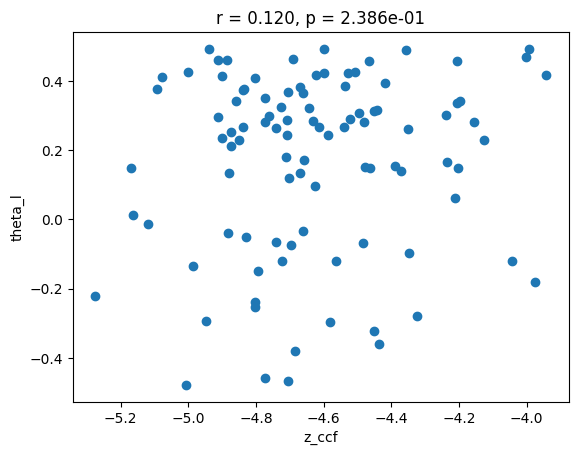

In [29]:
from scipy.stats import pearsonr
x_feature = 'z_ccf' 
y_feature = 'theta_l'
if x_feature == 'x_ccf':
    x = np.abs(combined_tagged_units_filtered[x_feature] + bregma_points_mm[2])
else:
    x = combined_tagged_units_filtered[x_feature]
y = model_combined[y_feature]
z = combined_tagged_units_filtered['z_ccf']

# Remove NaNs from both x and y
mask = ~(np.isnan(x) | np.isnan(y)) & (z<-3.5)
x = x[mask]
y = y[mask]

plt.scatter(x, y)

# correlation and p-value
corr, p = pearsonr(x, y)

plt.title(f"r = {corr:.3f}, p = {p:.3e}")
plt.xlabel(x_feature)
plt.ylabel(y_feature)

plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'correlation_{x_feature}_vs_{y_feature}_{criteria_name}.svg'), bbox_inches='tight')
plt.show()


# Compare with waveform features

In [22]:
features_wf = wf_features.columns.to_list()
features_wf.remove('session')
features_wf.remove('unit_id')
features_wf.remove('wf')
# features_wf.remove('gmm_label')
# features_wf.remove('kmeans_label')
# features_wf.remove('gmm_conf')
features_wf.remove('y_loc')
features_wf.remove('probe')
features_wf.remove('peak')
features_wf.remove('amp')

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter']
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_wf)))
gs = gridspec.GridSpec(len(features_wf), len(features_beh))
for i, feature in enumerate(features_wf):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter]
        y = features_combined[feature][filter]
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_wf_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')

# Compare with basic properties

In [226]:
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
features_be = basic_ephys_df.columns.to_list()
features_be.remove('session')
features_be.remove('unit_id')
features_be.remove('acg')
features_be.remove('acg_bl')
features_be.remove('be_filter')

In [ ]:
# compare all values in features_be with features_wf
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
fig = plt.figure(figsize=(len(features_beh) * 3, 3 * len(features_be)))
gs = gridspec.GridSpec(len(features_be), len(features_beh))
for i, feature in enumerate(features_be):
    for j, feature_be in enumerate(features_beh):
        ax = fig.add_subplot(gs[i, j])
        ax.scatter(features_combined[feature_be][filter], features_combined[feature][filter], c=features_combined['cluster'][filter], cmap='viridis', s=40, alpha=0.7, edgecolor='none')
        
        ax.set_xlabel(feature_be)
        ax.set_ylabel(feature)
        # correlation 
        x = features_combined[feature_be][filter].values
        y = features_combined[feature][filter].values
        corr, p = stats.pearsonr(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)])
        ax.set_title(f'r={corr:.2f} p={p:.2f}')
        if p < 0.05:
            ax.set_title(f'r={corr:.2f} p={p:.2e}', color='red')
plt.tight_layout()
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(beh_folder, f'compare_beh_basicephys_features_{criteria_name}_{waveform_criteria}{waveform_type}.png'), bbox_inches='tight')


# Compare outcome and go cue response

In [30]:
lm = LinearRegression()
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool) 
features_combined['be_filter'] = filter
focus_feature = 'response_rate'
X = features_combined[['pc_1', 'pc_2',  'pc_3']].values[filter]
y = features_combined[focus_feature].values[filter]

In [31]:
nan_filter = np.isnan(y) | np.isnan(X[:, 0])
lm.fit(X[~nan_filter], y[~nan_filter])
lm.coef_, lm.intercept_
focus_feature_predicted = np.full(np.sum(filter), np.nan)
focus_feature_predicted[~nan_filter] = lm.predict(X[~nan_filter])

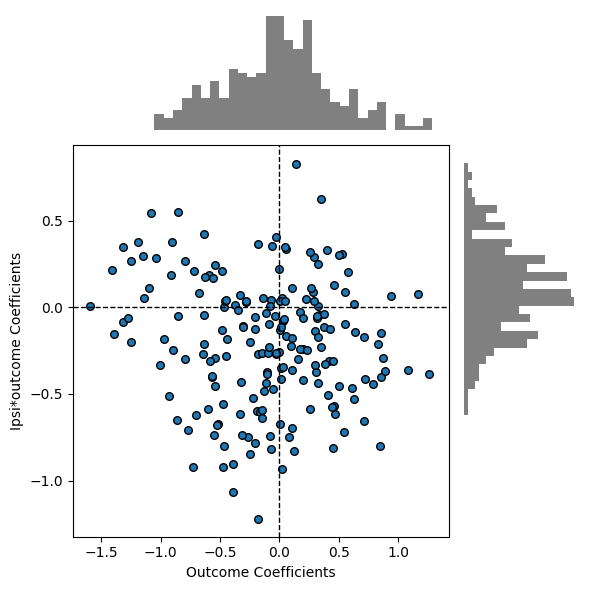

In [79]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'l'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 


curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_coefs_outcome[filter]-curr_coefs_int[filter], curr_coefs_q[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
# plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_coefs_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_coefs_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


In [34]:
thresh =0.05
all_vec = np.column_stack((curr_coefs_outcome[filter], curr_coefs_q[filter]))  # combine the coefficients for the reward outcome and Qchosen
all_vec = all_vec.astype(float)
# Convert Cartesian coordinates to polar coordinates
theta, rho = np.arctan2(all_vec[:, 1], all_vec[:, 0]), np.hypot(all_vec[:, 1], all_vec[:, 0])
bound_1 = -(1/4)*np.pi
bound_2 = np.pi
bound_3 = -np.pi
theta_scaled_dis  = np.full(len(theta), np.nan)
for ind, angle_curr in enumerate(theta):
    if bound_1 < angle_curr <= bound_2:
        theta_scaled_dis[ind] = (angle_curr-bound_1)/(bound_2-bound_1)
    else:
        theta_scaled_dis[ind] = (bound_1-angle_curr)/(bound_1-bound_3)
theta_scaled_dis_all = np.full(len(features_combined), np.nan)
theta_scaled_dis_all[filter] = theta_scaled_dis
features_combined['theta_scaled_dis'] = theta_scaled_dis_all

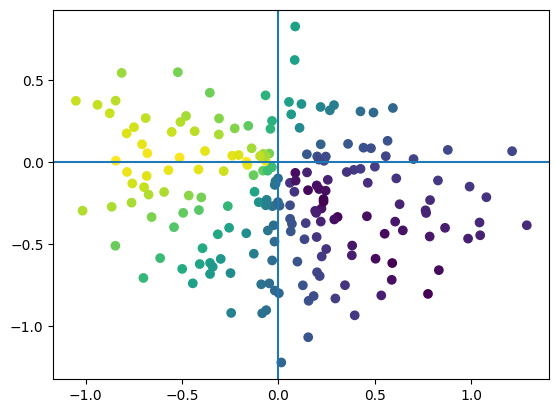

In [35]:
plt.scatter(curr_coefs_outcome[filter], curr_coefs_q[filter], c=theta_scaled_dis)
plt.axhline(0)
plt.axvline(0)

In [80]:
features_combined.groupby('tier_1').count()

,session,unit_id,T_Qchosen_e_ori,T_outcome_e_ori,T_ipsi_e_ori,T_outcome:ipsi_e_ori,T_amp_abs_e_ori,T_Qchosen_l_ori,T_outcome_l_ori,T_ipsi_l_ori,...,x_ccf_y,y_ccf_y,z_ccf_y,tier_1_y,tier_2_y,probe,x_ccf,y_ccf,z_ccf,tier_2
tier_1,,,,,,,,,,,,,,,,,,,,,
0.0,530,530,295,295,295,295,295,295,295,295,...,229,229,229,530,530,530,229,229,229,530
1.0,37,37,16,16,16,16,16,16,16,16,...,30,30,30,37,37,37,30,30,30,37


In [81]:
antidromic_df.groupby('tier_1').count()

,unit_id,session,p_auto_inhi,t_auto_inhi,p_collision,t_collision,p_antidromic,t_antidromic,tier_2,tier_1_long,tier_2_long
tier_1,,,,,,,,,,,
0.0,591,591,521,521,351,351,521,521,591,591,591
1.0,46,46,46,46,46,46,46,46,46,46,46


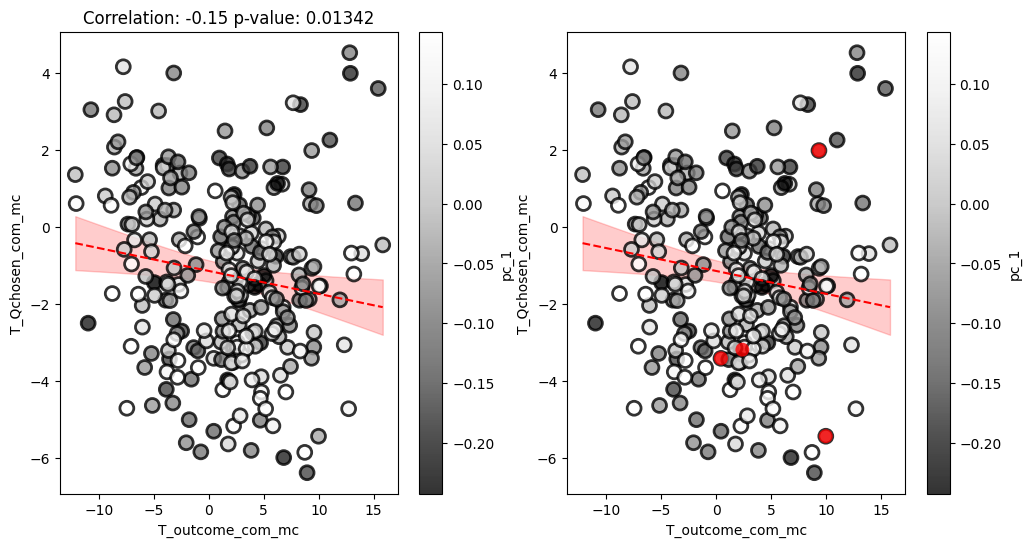

In [53]:
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
x_label = 'T_outcome_com_mc' #'response_rate' 
y_label = 'T_Qchosen_com_mc'
color_code = 'pc_1'
tier = 'tier_1'
num_bins = 3
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
# filter = filter & (features_combined['selected'])
# filter = filter & (features_combined['probe'] == 'tt')
# filter = filter & (features_combined['T_outcome_com_mc'].values <= 30)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# mean_x = np.zeros(num_bins)
# mean_y = np.zeros(num_bins)
# se_y = np.zeros(num_bins)

# for i in range(num_bins):
#     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
#     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
#     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
#     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# fit a regression line and add it to the plot
# Reshape for sklearn
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

X = x_vals.reshape(-1, 1)

# Fit model
lm = LinearRegression()
lm.fit(X, y_vals)
y_pred = lm.predict(X)

# Calculate residuals and standard error
residuals = y_vals - y_pred
dof = len(x_vals) - 2  # degrees of freedom
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# Confidence interval (95%)
t_val = t.ppf(0.975, dof)

# Prediction standard error at each x
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# Upper and lower CI
y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for nice line plot
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Plot regression line
axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


# Plot regression line
axes[1].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# Plot confidence band
axes[1].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')

if color_code == 'probe':
    probe_types = np.unique(features_combined['probe'].values)
    probe_color_map = {probe: idx for idx, probe in enumerate(probe_types)}
    color_code_values = features_combined[color_code].values[filter][~nan_mask]
    color_code_values = np.array([probe_color_map[probe] for probe in color_code_values])
else:
    color_code_values = features_combined[color_code].values[filter][~nan_mask].astype(float)
color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
color_code_values[color_code_values>=color_code_95]=color_code_95
color_code_values[color_code_values<=color_code_5]=color_code_5
im = axes[0].scatter(x_vals, y_vals, c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[0].set_xlabel(x_label)
axes[0].set_ylabel(y_label)
plt.colorbar(im, label=color_code)
# axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
# corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
corr, p = pearsonr(x_vals, y_vals)
axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


im = axes[1].scatter(x_vals, y_vals, c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel(y_label)
plt.colorbar(im, label=color_code)

# # anti cells
# anti_thresh = 2
features_combined_anti = features_combined[(features_combined[tier].astype(bool)) & (features_combined['be_filter']) & (features_combined['selected'])]

# nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
# x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

axes[1].scatter(features_combined_anti[x_label].values, features_combined_anti[y_label].values, color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

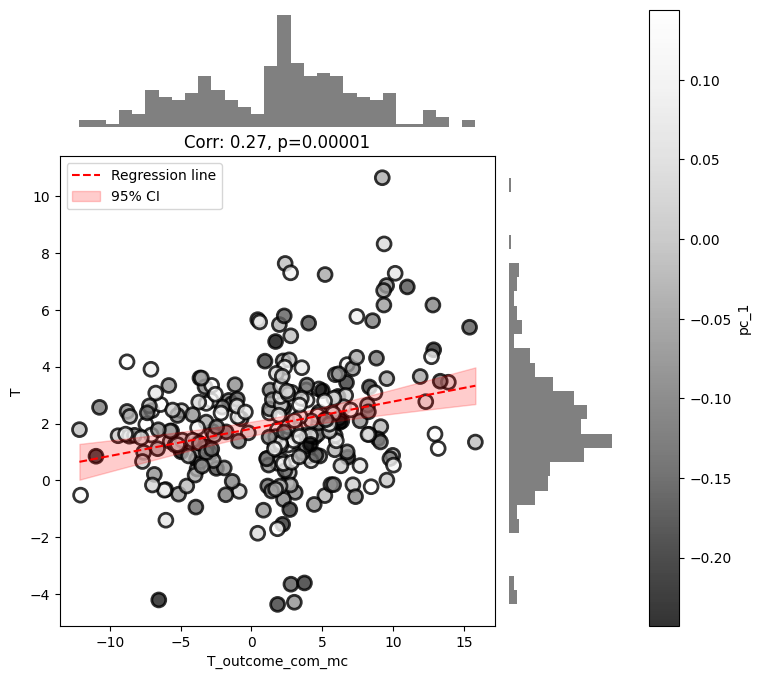

In [74]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import t, pearsonr
from sklearn.linear_model import LinearRegression
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
# filter = filter & (features_combined['bl_mean'].values >= 2)
nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# Extract data
x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)
color_vals = features_combined[color_code].values[filter][~nan_mask].astype(float)

# Clip color range for better visualization
color_code_5 = np.nanquantile(color_vals, 0.01)
color_code_95 = np.nanquantile(color_vals, 0.90)
color_vals = np.clip(color_vals, color_code_5, color_code_95)

# Fit regression
X = x_vals.reshape(-1, 1)
lm = LinearRegression().fit(X, y_vals)
y_pred = lm.predict(X)

# Confidence interval
residuals = y_vals - y_pred
dof = len(x_vals) - 2
residual_std_error = np.sqrt(np.sum(residuals**2) / dof)
t_val = t.ppf(0.975, dof)
se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

y_upper = y_pred + t_val * se_pred
y_lower = y_pred - t_val * se_pred

# Sort for smooth CI band
sorted_idx = np.argsort(x_vals)
x_sorted = x_vals[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_upper_sorted = y_upper[sorted_idx]
y_lower_sorted = y_lower[sorted_idx]

# Create figure with gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.1, wspace=0.05)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
sc = ax_main.scatter(x_vals, y_vals, c=color_vals, cmap='Greys_r', s=100, edgecolors='k', linewidths=2, alpha=0.8)
ax_main.plot(x_sorted, y_pred_sorted, 'r--', label='Regression line')
ax_main.fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')
ax_main.set_xlabel(x_label)
ax_main.set_ylabel(y_label)
corr, p = pearsonr(x_vals, y_vals)
ax_main.set_title(f'Corr: {corr:.2f}, p={p:.5f}')
ax_main.legend()

# Histogram on top (X axis)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_histx.hist(x_vals, bins=30, color='gray')
ax_histx.axis('off')

# Histogram on right (Y axis)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_histy.hist(y_vals, bins=30, orientation='horizontal', color='gray')
ax_histy.axis('off')

# Colorbar
cbar = fig.colorbar(sc, ax=[ax_main, ax_histx, ax_histy], orientation='vertical', fraction=0.05)
cbar.set_label(color_code)

# Save
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}_marginal_hist.svg'), bbox_inches='tight')

plt.show()


In [122]:
from sklearn.decomposition import PCA
import numpy as np

# Prepare data
x = features_combined[x_label].values[filter][~nan_mask].astype(float)
y = features_combined[y_label].values[filter][~nan_mask].astype(float)

# Stack into 2D array
X = np.column_stack([x, y])

# Fit PCA (1D line)
pca = PCA(n_components=1)
pca.fit(X)

# Mean and direction of best-fitting line
center = pca.mean_
direction = pca.components_[0]

# Project each point onto the line (2D projection)
proj_length = (X - center) @ direction      # signed coordinate along line
projected = center + np.outer(proj_length, direction)  # 2D projected coordinates

# Create "fitted line" samples for visualization (like x_fit/y_fit)
proj_min, proj_max = proj_length.min(), proj_length.max()
x_fit_line = np.linspace(proj_min, proj_max, 500)
curve = center + np.outer(x_fit_line, direction)
x_fit, y_fit = curve[:, 0], curve[:, 1]

# Normalize 1D coordinate along line
projected_1d = proj_length
projected_1d_norm = (projected_1d - projected_1d.min()) / (projected_1d.max() - projected_1d.min())


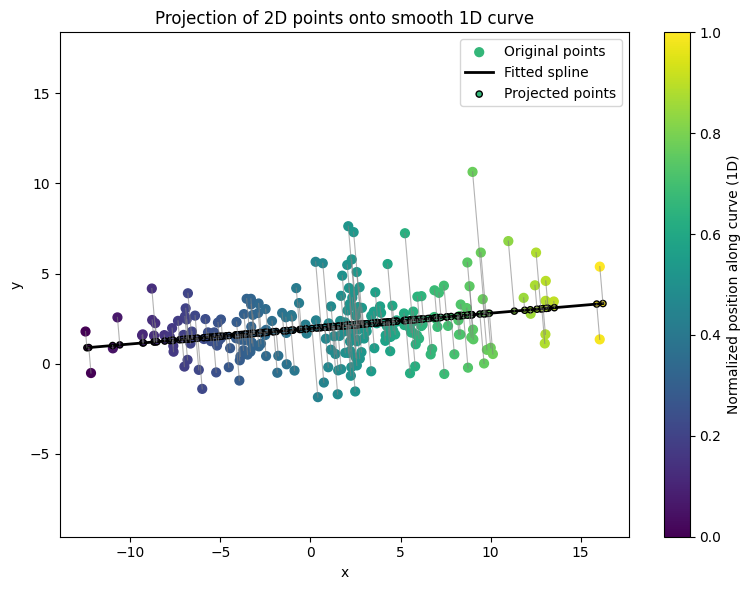

In [123]:
plt.figure(figsize=(8,6))

# Original scatter
plt.scatter(x, y, c=projected_1d_norm, cmap='viridis', s=40, label='Original points')

# Fitted spline
plt.plot(x_fit, y_fit, 'k-', lw=2, label='Fitted spline')

# Projections (lines from each point to curve)
x_proj, y_proj = projected[:, 0], projected[:, 1]
for xi, yi, xpi, ypi in zip(x, y, x_proj, y_proj):
    plt.plot([xi, xpi], [yi, ypi], 'gray', lw=0.8, alpha=0.6)

# Projected points
plt.scatter(x_proj, y_proj, c=projected_1d_norm, cmap='viridis', s=20, edgecolor='k', label='Projected points')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Projection of 2D points onto smooth 1D curve')
plt.legend()
plt.colorbar(label='Normalized position along curve (1D)')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [2]:
proj_1d_all = np.full(len(features_combined), np.nan)
proj_1d_all[filter][~nan_mask] = projected_1d_norm
features_combined['proj_1d'] = proj_1d_all

NameError: name 'np' is not defined

In [1]:
# from scipy.stats import t, pearsonr
# from sklearn.linear_model import LinearRegression
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# x_label = 'T_outcome_com_mc' #'response_rate' 
# y_label = 'T'
# color_code = 'pc_1'
# num_bins = 3
# filter = features_combined['be_filter'].values
# filter = np.array(filter, dtype=bool)
# # filter = filter & (features_combined['bl_mean'].values >= 2)
# nan_mask = features_combined[filter][x_label].isnull() | features_combined[filter][y_label].isnull()
# # bin_edges = np.linspace(np.nanmin(features_combined[x_label].values[filter]), np.nanmax(features_combined[x_label].values[filter]), num_bins+1)
# # # bin_edges = np.quantile(features_combined[x_label].values[filter][~nan_mask], np.linspace(0, 1, num_bins+1))
# # mean_x = np.zeros(num_bins)
# # mean_y = np.zeros(num_bins)
# # se_y = np.zeros(num_bins)

# # for i in range(num_bins):
# #     bin_mask = (features_combined[x_label].values[filter] >= bin_edges[i]) & (features_combined[x_label].values[filter] < bin_edges[i+1])
# #     mean_x[i] = np.nanmean(features_combined[x_label].values[filter][bin_mask])
# #     mean_y[i] = np.nanmean(features_combined[y_label].values[filter][bin_mask])
# #     se_y[i] = stats.sem(features_combined[y_label].values[filter][bin_mask], nan_policy='omit')
# # fit a regression line and add it to the plot
# # Reshape for sklearn
# x_vals = features_combined[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined[y_label].values[filter][~nan_mask].astype(float)

# X = x_vals.reshape(-1, 1)

# # Fit model
# lm = LinearRegression()
# lm.fit(X, y_vals)
# y_pred = lm.predict(X)

# # Calculate residuals and standard error
# residuals = y_vals - y_pred
# dof = len(x_vals) - 2  # degrees of freedom
# residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

# # Confidence interval (95%)
# t_val = t.ppf(0.975, dof)

# # Prediction standard error at each x
# se_pred = residual_std_error * np.sqrt(1/len(x_vals) + (x_vals - np.mean(x_vals))**2 / np.sum((x_vals - np.mean(x_vals))**2))

# # Upper and lower CI
# y_upper = y_pred + t_val * se_pred
# y_lower = y_pred - t_val * se_pred

# # Sort for nice line plot
# sorted_idx = np.argsort(x_vals)
# x_sorted = x_vals[sorted_idx]
# y_pred_sorted = y_pred[sorted_idx]
# y_upper_sorted = y_upper[sorted_idx]
# y_lower_sorted = y_lower[sorted_idx]

# # Plot regression line
# axes[0].plot(x_sorted, y_pred_sorted, color='r', linestyle='--', label='Regression line')

# # Plot confidence band
# axes[0].fill_between(x_sorted, y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% CI')


# color_code_values = features_combined[color_code].values[filter].astype(float)
# color_code_5 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.01)
# color_code_95 = np.quantile(color_code_values[~np.isnan(color_code_values)], 0.90)
# color_code_values[color_code_values>=color_code_95]=color_code_95
# color_code_values[color_code_values<=color_code_5]=color_code_5
# im = axes[0].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
# axes[0].set_xlabel(x_label)
# axes[0].set_ylabel(y_label)
# plt.colorbar(im, label=color_code)
# # axes[0].errorbar(mean_x, mean_y, yerr=se_y, fmt='-o', color='k', label='Mean with SE')
# corr, p = pearsonr(features_combined[x_label].values[filter][~nan_mask].astype(float), features_combined[y_label].values[filter][~nan_mask].astype(float))
# axes[0].set_title(f'Correlation: {corr:.2f} p-value: {p:.5f}')


# im = axes[1].scatter(features_combined[x_label].values[filter], features_combined[y_label].values[filter], c = color_code_values, alpha = 0.8, edgecolors='k', s = 100, linewidths=2, cmap = 'Greys_r')
# axes[1].set_xlabel(x_label)
# axes[1].set_ylabel(y_label)
# plt.colorbar(im, label=color_code)

# # anti cells
# anti_thresh = 2
# filter_anti = features_combined_anti['be_filter'].values
# filter_anti = np.array(filter_anti, dtype=bool)
# filter_anti = filter_anti & (features_combined_anti['anti_resp'].values <= anti_thresh) & (features_combined_anti['anti_resp'].values >= 1)
# nan_mask = features_combined_anti[filter_anti][x_label].isnull() | features_combined_anti[filter_anti][y_label].isnull()
# x_vals = features_combined_anti[x_label].values[filter][~nan_mask].astype(float)
# y_vals = features_combined_anti[y_label].values[filter][~nan_mask].astype(float)

# axes[1].scatter(features_combined_anti[x_label].values[filter_anti], features_combined_anti[y_label].values[filter_anti], color = 'r', alpha = 0.8, edgecolors='none', s = 100, linewidths=2)

# fig.savefig(fname=os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(beh_folder, f'{x_label}_vs_{y_label}_color_{color_code}_{criteria_name}.svg'), bbox_inches='tight')

In [84]:
# scatter and polar of 'outcome' and 'Qchosen'
period = 'com'
verion = 'mc'  # 'ori' or 'mc'
c_or_t = 'T'
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)
if 'outcome:ipsi' in regressors_focus:
    curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
    curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
    curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 
else:
    curr_coefs_int = np.zeros(len(model_combined))
    curr_p_int = np.ones(len(model_combined))

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values  # get the p-values for the reward outcome

color_code = 'response_rate'
color_code_var = features_combined[color_code].values.astype(float)
color_top = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.85)
color_bottom = np.quantile(color_code_var[~np.isnan(color_code_var)], 0.05)
color_code_var[color_code_var >= color_top] = color_top
color_code_var[color_code_var <= color_bottom] = color_bottom                                                                                                                               
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.scatter(curr_T_outcome[filter], curr_T_int[filter], edgecolors='k', s=30, label='outcome p<0.05')
ax_scatter.axhline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.axvline(0, color='k', linestyle='--', linewidth=1)
ax_scatter.set_xlabel('Outcome Coefficients')
ax_scatter.set_ylabel('Ipsi*outcome Coefficients')
plt.colorbar(im)

# Histogram for X-axis
ax_histx.hist(curr_T_outcome, bins=30, color='gray')
ax_histx.axis('off')  # hide ticks and labels

# Histogram for Y-axis (horizontal)
ax_histy.hist(curr_T_int, bins=30, color='gray', orientation='horizontal')
ax_histy.axis('off')  # hide ticks and labels

plt.tight_layout()
plt.show()


NameError: name 'regressors_focus' is not defined

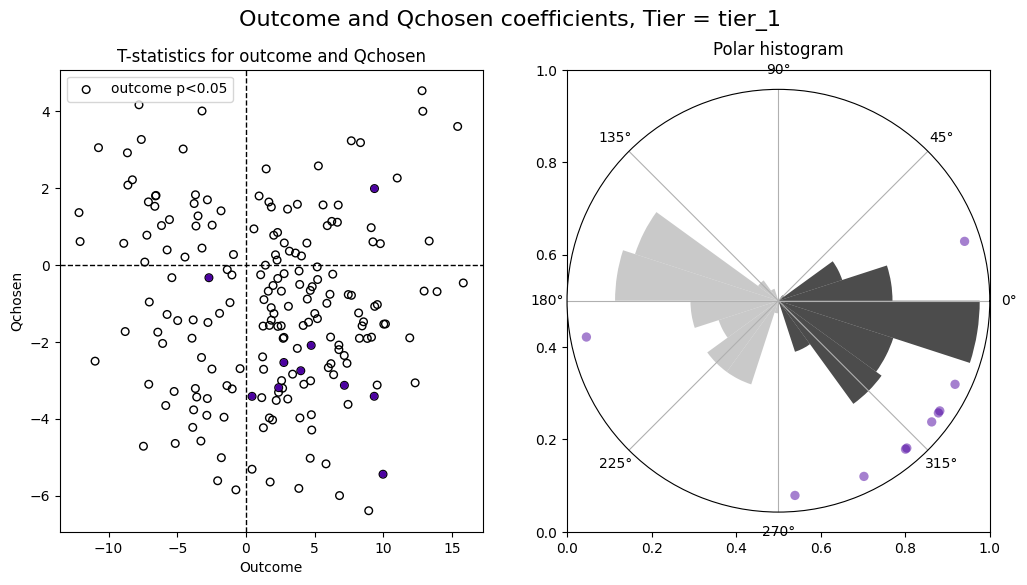

In [76]:
period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'T'
tier = 'tier_1'
thresh = 0.05
filter = features_combined['be_filter'].values
filter = np.array(filter, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

curr_p_int = features_combined[f'p_outcome:ipsi_{period}_{verion}'].values
curr_coefs_int = features_combined[f'coef_outcome:ipsi_{period}_{verion}'].values 
curr_T_int = features_combined[f'T_outcome:ipsi_{period}_{verion}'].values 

curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]

curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]  # get the T-statistics for the reward outcome
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]  # get the T-statistics for the Qchosen
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]  # get the p-values for the reward outcome
# scatter of outcome and Qchosen coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all = curr_T_outcome
qchosen_T_all = curr_T_q
outcome_coef_all = curr_coefs_outcome
qchosen_coef_all = curr_coefs_q
outcome_P_all = curr_p_outcome

axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label = 'outcome p<0.05')
# axes[0].scatter(outcome_T_all[outcome_P_all>=thresh], qchosen_T_all[curr_p_outcome>=thresh], color='none', edgecolors='lightgray', s=30, label = 'outcome p>=0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# polar
edges = np.linspace(-np.pi, np.pi, 4*5+1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((outcome_coef_all[outcome_P_all<thresh], qchosen_coef_all[outcome_P_all<thresh]))  # combine the coefficients for the reward outcome and Qchosen
# Convert Cartesian coordinates to polar coordinates
cat_mask = outcome_coef_all[outcome_P_all<thresh]>0
# Create polar histogram
# positive
theta, rho = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0]), np.hypot(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0.7, 0.7, 0.7], alpha=0.7, edgecolor='none', density=True)
# negative
theta, rho = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0]), np.hypot(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta, bins=edges, color=[0, 0, 0], alpha=0.7, edgecolor='none', density=True)
axes[1].set_yticks([])
axes[1].set_title('Polar histogram')
# antidromic ones:
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]  # get the T-statistics for the reward outcome
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]  # get the T-statistics for the Qchosen
new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))  # combine the coefficients for the reward outcome and Qchosen
theta, rho = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0]), np.hypot(new_vec_anti[:, 1], new_vec_anti[:, 0])
axes[1].scatter(theta, 0.9 * np.ones_like(theta), color=(76/255, 2/255, 161/255), alpha=0.5, edgecolors='none', s=45)
# axes[1].hist(theta, bins=edges, color='red', alpha=0.7, edgecolor='none', density=True)
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti, color=(76/255, 2/255, 161/255), edgecolors='none', s=25, label='anti cells')
# set box and axis to be invisible
# axes[1].get_xaxis().set_visible(False)
# axes[1].get_yaxis().set_visible(False)
plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
plt.savefig(os.path.join(beh_folder, f'Combined_Summary_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}.pdf'), bbox_inches='tight')

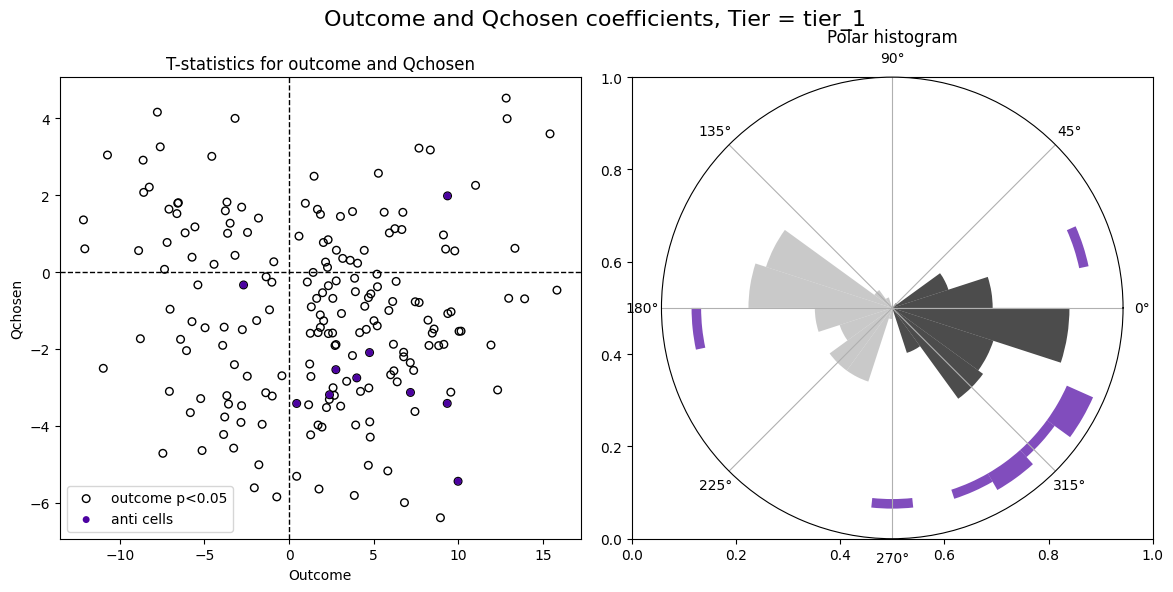

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

period = 'com'
verion = 'ori'  # 'ori' or 'mc'
c_or_t = 'T'
tier = 'tier_1'
thresh = 0.05

# --- filtering ---
filter = np.array(features_combined['be_filter'].values, dtype=bool)
filter = filter & (features_combined['bl_mean'].values >= 2)

# --- coefficients and stats ---
curr_coefs_outcome = features_combined[f'coef_outcome_{period}_{verion}'].values[filter]
curr_coefs_q = features_combined[f'coef_Qchosen_{period}_{verion}'].values[filter]
curr_T_outcome = features_combined[f'T_outcome_{period}_{verion}'].values[filter]
curr_T_q = features_combined[f'T_Qchosen_{period}_{verion}'].values[filter]
curr_p_outcome = features_combined[f'p_outcome_{period}_{verion}'].values[filter]

# --- figure setup ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
outcome_T_all, qchosen_T_all = curr_T_outcome, curr_T_q
outcome_coef_all, qchosen_coef_all = curr_coefs_outcome, curr_coefs_q
outcome_P_all = curr_p_outcome

# === Scatter of T-values ===
axes[0].scatter(outcome_T_all, qchosen_T_all, color='none', edgecolors='k', s=30, label='outcome p<0.05')
axes[0].set_xlabel('Outcome')
axes[0].set_ylabel('Qchosen')
axes[0].set_title('T-statistics for outcome and Qchosen')
axes[0].axhline(0, color='k', linestyle='--', linewidth=1)
axes[0].axvline(0, color='k', linestyle='--', linewidth=1)
axes[0].legend()

# === Polar histogram (main background) ===
edges = np.linspace(-np.pi, np.pi, 4 * 5 + 1)
axes[1] = fig.add_subplot(122, polar=True)
all_vec = np.column_stack((
    outcome_coef_all[outcome_P_all < thresh],
    qchosen_coef_all[outcome_P_all < thresh]
))
cat_mask = outcome_coef_all[outcome_P_all < thresh] > 0

# positive (gray)
theta_pos = np.arctan2(all_vec[~cat_mask, 1], all_vec[~cat_mask, 0])
axes[1].hist(theta_pos, bins=edges, color=[0.7, 0.7, 0.7],
             alpha=0.7, edgecolor='none', density=True)
# negative (black)
theta_neg = np.arctan2(all_vec[cat_mask, 1], all_vec[cat_mask, 0])
axes[1].hist(theta_neg, bins=edges, color=[0, 0, 0],
             alpha=0.7, edgecolor='none', density=True)

axes[1].set_yticks([])
axes[1].set_title('Polar histogram')

# === Antidromic data (for outer circular histogram) ===
mask = (features_combined[tier].astype(bool)) & (features_combined['be_filter'])
curr_coefs_outcome_anti = features_combined[f'coef_outcome_{period}_{verion}'].values[mask]
curr_coefs_q_anti = features_combined[f'coef_Qchosen_{period}_{verion}'].values[mask]
curr_T_outcome_anti = features_combined[f'T_outcome_{period}_{verion}'].values[mask]
curr_T_q_anti = features_combined[f'T_Qchosen_{period}_{verion}'].values[mask]

new_vec_anti = np.column_stack((curr_coefs_outcome_anti, curr_coefs_q_anti))
theta = np.arctan2(new_vec_anti[:, 1], new_vec_anti[:, 0])

# --- add circular histogram around the edge ---
num_bins = 30
counts, bin_edges = np.histogram(theta, bins=num_bins, range=(-np.pi, np.pi), density=False)
counts = counts / counts.max()  # normalize for visualization

color_anti = np.array([76/255, 2/255, 161/255])
r_base = 1.0  # radius of outer circle
r_height = 0.15  # height of histogram bars

# plot bars as radial rectangles
for i in range(num_bins):
    theta_start = bin_edges[i]
    theta_end = bin_edges[i + 1]
    theta_center = 0.5 * (theta_start + theta_end)
    width = theta_end - theta_start
    height = r_height * counts[i]
    axes[1].bar(theta_center, height, width=width,
                bottom=r_base, color=color_anti, alpha=0.7, edgecolor='none', linewidth=0)

# overlay antidromic scatter on T–T plot
axes[0].scatter(curr_T_outcome_anti, curr_T_q_anti,
                color=color_anti, edgecolors='none', s=25, label='anti cells')

plt.suptitle(f'Outcome and Qchosen coefficients, Tier = {tier}', fontsize=16)
axes[0].legend()
plt.tight_layout()
plt.savefig(os.path.join(
    beh_folder,
    f'Combined_Summary_outcome_Qchosen_coeffs_{criteria_name}_with_anti_at_{tier}.pdf'
), bbox_inches='tight')
plt.show()


In [86]:
np.sum(features_combined[tier].astype(bool))

np.int64(37)